# Earthquakes and the wealth of nations
### Diaz - Paniagua - Larroulet

We prepare the study data using a `Dataprep` object that describes all the details needed to define the synthetic control study. This works similarly to the `dataprep` method in the `R` package `synth`.

(For an explanation of each of the `Dataprep` arguments, see the package [documentation](https://sdfordham.github.io/pysyncon/dataprep.html#pysyncon.Dataprep)).

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

CHILE_PLOT_YAXIS_LABEL = 'GDP per Capita (Millions of CLP)'

In [2]:
from pysyncon import Dataprep, Synth
from pysyncon.utils import PlaceboTest
import sys
sys.path.insert(0, '../src')
import process_chile_gdp_data as pcd

df = pcd.process_data_for_synth()

dataprep = Dataprep(
    foo=df,
    predictors=['agropecuario', 'pesca', 'mineria', 'industria_m',
       'electricidad', 'construccion', 'comercio', 'transporte',
       'servicios_financieros', 'vivienda', 'personales', 'publica'],
    predictors_op="mean",
    time_predictors_prior=range(2005, 2009),
    special_predictors=[
        ("gdp_cap", range(2005, 2009), "mean"),
        ("ed_superior_cap", range(2008, 2009), "mean")
    ],
    dependent="gdp_cap",
    unit_variable="region_name",
    time_variable="year",
    treatment_identifier="VII Del Maule",
    controls_identifier=[
        'I De Tarapacá', 'II De Antofagasta', 'III De Atacama',
       'IV De Coquimbo', 'V De Valparaíso',
       'RMS Región Metropolitana de Santiago',
       'VI Del Libertador General Bernardo OHiggins', 
       'IX De La Araucanía', 'X De Los Lagos',
       'XI Aysén del General Carlos Ibáñez del Campo',
       'XII De Magallanes y de la Antártica Chilena'
    ],
    time_optimize_ssr=range(1990, 2009),
)


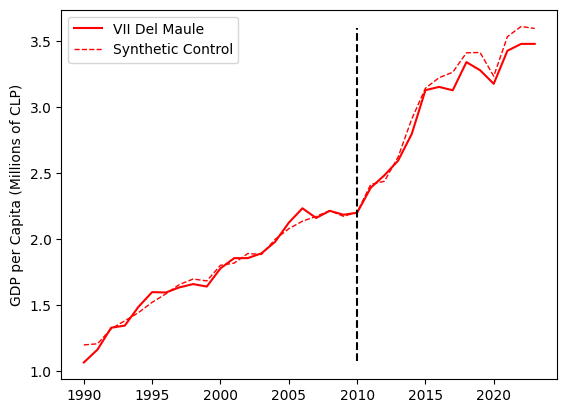

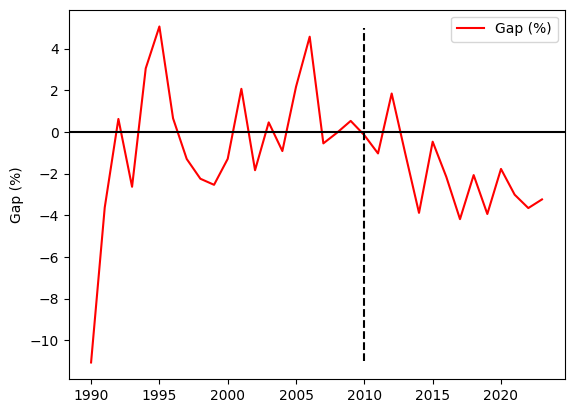

In [3]:
import util
import importlib
from matplotlib import pyplot as plt
importlib.reload(util)

synth = Synth()
synth.fit(dataprep=dataprep, optim_method="Nelder-Mead", optim_initial="ols")
cl_res = util.synth_plot_chile(synth, time_period=range(1990, 2024), treatment_time=2010, filename='maule_gdp_paths.png')
util.gap_plot(synth, time_period=range(1990, 2024), treatment_time=2010, filename='maule_gap.png')

In [4]:
cl_res

,Synthetic Control,VII Del Maule
year,,
1990,1.200525e+06,1.067627e+06
1991,1.209044e+06,1.165204e+06
1992,1.322088e+06,1.330370e+06
1993,1.383242e+06,1.346842e+06
1994,1.444969e+06,1.489088e+06
1995,1.523021e+06,1.600176e+06
1996,1.586691e+06,1.597086e+06
1997,1.657750e+06,1.636252e+06
1998,1.699206e+06,1.661033e+06


## Denominator effect: SCM on Population and Total GDP

To rule out migration bias in Y/L (GDP per capita), we run SCM on Population and Total Regional GDP using the same predictors. Stable paths support the per-capita interpretation.

In [ ]:
# Denominator effect: Population SCM
import util
import importlib
importlib.reload(util)
df_denom = df.dropna(subset=['Population', 'gdp_total'])
dataprep_pop = Dataprep(
    foo=df_denom,
    predictors=['agropecuario', 'pesca', 'mineria', 'industria_m',
       'electricidad', 'construccion', 'comercio', 'transporte',
       'servicios_financieros', 'vivienda', 'personales', 'publica'],
    predictors_op="mean",
    time_predictors_prior=range(2005, 2009),
    special_predictors=[
        ("gdp_cap", range(2005, 2009), "mean"),
        ("ed_superior_cap", range(2008, 2009), "mean")
    ],
    dependent="Population",
    unit_variable="region_name",
    time_variable="year",
    treatment_identifier="VII Del Maule",
    controls_identifier=[
        'I De Tarapacá', 'II De Antofagasta', 'III De Atacama',
       'IV De Coquimbo', 'V De Valparaíso',
       'RMS Región Metropolitana de Santiago',
       'VI Del Libertador General Bernardo OHiggins',
       'IX De La Araucanía', 'X De Los Lagos',
       'XI Aysén del General Carlos Ibáñez del Campo',
       'XII De Magallanes y de la Antártica Chilena'
    ],
    time_optimize_ssr=range(1990, 2009),
)
synth_pop = Synth()
synth_pop.fit(dataprep=dataprep_pop, optim_method="Nelder-Mead", optim_initial="ols")
importlib.reload(util)
util.synth_plot_population(synth_pop, time_period=range(1990, 2024), treatment_time=2010,
    filename='maule_pop_paths.png', divide_by=1000, ylabel='Population (thousands)')

# Denominator effect: Total GDP SCM
dataprep_gdp = Dataprep(
    foo=df_denom,
    predictors=['agropecuario', 'pesca', 'mineria', 'industria_m',
       'electricidad', 'construccion', 'comercio', 'transporte',
       'servicios_financieros', 'vivienda', 'personales', 'publica'],
    predictors_op="mean",
    time_predictors_prior=range(2005, 2009),
    special_predictors=[
        ("gdp_cap", range(2005, 2009), "mean"),
        ("ed_superior_cap", range(2008, 2009), "mean")
    ],
    dependent="gdp_total",
    unit_variable="region_name",
    time_variable="year",
    treatment_identifier="VII Del Maule",
    controls_identifier=[
        'I De Tarapacá', 'II De Antofagasta', 'III De Atacama',
       'IV De Coquimbo', 'V De Valparaíso',
       'RMS Región Metropolitana de Santiago',
       'VI Del Libertador General Bernardo OHiggins',
       'IX De La Araucanía', 'X De Los Lagos',
       'XI Aysén del General Carlos Ibáñez del Campo',
       'XII De Magallanes y de la Antártica Chilena'
    ],
    time_optimize_ssr=range(1990, 2009),
)
synth_gdp = Synth()
synth_gdp.fit(dataprep=dataprep_gdp, optim_method="Nelder-Mead", optim_initial="ols")
util.synth_plot_gdp_total(synth_gdp, time_period=range(1990, 2024), treatment_time=2010,
    filename='maule_gdp_total_paths.png', divide_by=1e9, ylabel='Total GDP (billions CLP)')

In [5]:
synth.weights()

I De Tarapacá                                   0.000
II De Antofagasta                               0.000
III De Atacama                                  0.000
IV De Coquimbo                                  0.000
V De Valparaíso                                 0.000
RMS Región Metropolitana de Santiago            0.000
VI Del Libertador General Bernardo OHiggins     0.323
IX De La Araucanía                              0.356
X De Los Lagos                                  0.321
XI Aysén del General Carlos Ibáñez del Campo    0.000
XII De Magallanes y de la Antártica Chilena     0.000
Name: weights, dtype: float64

### Rolling in-time placebos
Placebo for every pre-treatment year (1996–2009) to show that 2010 is uniquely extreme.

In [ ]:
# In-time placebos: fake treatment years 1996-2009
placebo_gaps_cl = {}
for t in range(1996, 2010):
    dp = Dataprep(
        foo=df,
        predictors=['agropecuario', 'pesca', 'mineria', 'industria_m',
           'electricidad', 'construccion', 'comercio', 'transporte',
           'servicios_financieros', 'vivienda', 'personales', 'publica'],
        predictors_op="mean",
        time_predictors_prior=range(2005, 2009),
        special_predictors=[
            ("gdp_cap", range(2005, 2009), "mean"),
            ("ed_superior_cap", range(2008, 2009), "mean")
        ],
        dependent="gdp_cap",
        unit_variable="region_name",
        time_variable="year",
        treatment_identifier="VII Del Maule",
        controls_identifier=[
            'I De Tarapacá', 'II De Antofagasta', 'III De Atacama',
           'IV De Coquimbo', 'V De Valparaíso',
           'RMS Región Metropolitana de Santiago',
           'VI Del Libertador General Bernardo OHiggins',
           'IX De La Araucanía', 'X De Los Lagos',
           'XI Aysén del General Carlos Ibáñez del Campo',
           'XII De Magallanes y de la Antártica Chilena'
        ],
        time_optimize_ssr=range(1990, t),
    )
    s = Synth()
    s.fit(dataprep=dp, optim_method="Nelder-Mead", optim_initial="ols")
    Z0, Z1 = s.dataprep.make_outcome_mats(time_period=range(1990, 2024))
    ts = s._synthetic(Z0=Z0)
    gap = (Z1.iloc[:, 0] - ts.iloc[:, 0]) / ts.iloc[:, 0].replace(0, 1e-10) * 100
    placebo_gaps_cl[t] = gap
# Actual treated gap (from main synth)
Z0_act, Z1_act = synth.dataprep.make_outcome_mats(time_period=range(1990, 2024))
ts_act = synth._synthetic(Z0=Z0_act)
actual_gap_cl = (Z1_act.iloc[:, 0] - ts_act.iloc[:, 0]) / ts_act.iloc[:, 0].replace(0, 1e-10) * 100
util.in_time_placebo_plot(placebo_gaps_cl, actual_gap_cl, time_period=range(1990, 2024),
    actual_treatment_year=2010, divide_by=1, y_axis_label='Gap (%)', y_axis_limit=15,
    filename='maule_in_time_placebos.png')

In [6]:
synth.summary()

,V,treated,synthetic,sample mean
agropecuario,0.083,0.165,0.138,0.057
pesca,0.017,0.000,0.041,0.041
mineria,0.724,0.005,0.034,0.162
industria_m,0.001,0.218,0.140,0.131
electricidad,0.001,0.089,0.024,0.024
construccion,0.001,0.077,0.091,0.088
comercio,0.027,0.059,0.105,0.094
transporte,0.000,0.104,0.100,0.095
servicios_financieros,0.021,0.072,0.091,0.097
vivienda,0.126,0.056,0.058,0.053


### Maule sectoral SCM (Construction, Other_Sectors)
Sector-level SCM for comparability with Canterbury. Construction share and all other sectors.

In [ ]:
# Maule sectoral SCM: Construction and Other_Sectors
chile_sectors = ['agropecuario', 'pesca', 'mineria', 'industria_m', 'electricidad', 'construccion',
    'comercio', 'transporte', 'servicios_financieros', 'vivienda', 'personales', 'publica']
df['Other_Sectors'] = 1 - df['construccion']  # All other sectors
controls_cl = ['I De Tarapacá', 'II De Antofagasta', 'III De Atacama', 'IV De Coquimbo', 'V De Valparaíso',
    'RMS Región Metropolitana de Santiago', 'VI Del Libertador General Bernardo OHiggins',
    'IX De La Araucanía', 'X De Los Lagos', 'XI Aysén del General Carlos Ibáñez del Campo',
    'XII De Magallanes y de la Antártica Chilena']
for dep, fname in [('construccion', 'maule_scm_Construction.png'), ('Other_Sectors', 'maule_scm_Other_Sectors.png')]:
    pred_lst = ['construccion'] if dep == 'Other_Sectors' else [c for c in chile_sectors if c != dep]
    dp = Dataprep(foo=df, predictors=pred_lst, predictors_op="mean", time_predictors_prior=range(2005, 2009),
        special_predictors=[("gdp_cap", range(2005, 2009), "mean"), ("ed_superior_cap", range(2008, 2009), "mean")],
        dependent=dep, unit_variable="region_name", time_variable="year",
        treatment_identifier="VII Del Maule", controls_identifier=controls_cl,
        time_optimize_ssr=range(1990, 2009))
    s = Synth()
    s.fit(dataprep=dp, optim_method="Nelder-Mead", optim_initial="ols")
    util.synth_plot_sector(s, time_period=range(1990, 2024), treatment_time=2010, filename=fname, sector='Chile')

We can run a Placebo test using the `PlaceboTest` class. After instantiating it, we supply the original `Dataprep` object to it as well as a synthetic control method object (our `synth` from previously) and any options that we want to supply to the synthetic control method object (the optimisation scheme and starting point for the optimisation scheme).

In [7]:
placebo_test = PlaceboTest()
placebo_test.fit(
    dataprep=dataprep,
    scm=synth,
    scm_options={"optim_method": "Nelder-Mead", "optim_initial": "ols"},
)

(1/11) Completed placebo test for XII De Magallanes y de la Antártica Chilena.


(2/11) Completed placebo test for IV De Coquimbo.


(3/11) Completed placebo test for IX De La Araucanía.


(4/11) Completed placebo test for RMS Región Metropolitana de Santiago.


(5/11) Completed placebo test for I De Tarapacá.


(6/11) Completed placebo test for X De Los Lagos.


(7/11) Completed placebo test for V De Valparaíso.


(8/11) Completed placebo test for VI Del Libertador General Bernardo OHiggins.


(9/11) Completed placebo test for XI Aysén del General Carlos Ibáñez del Campo.


(10/11) Completed placebo test for II De Antofagasta.


(11/11) Completed placebo test for III De Atacama.


Calculating treated unit gaps.


Done.


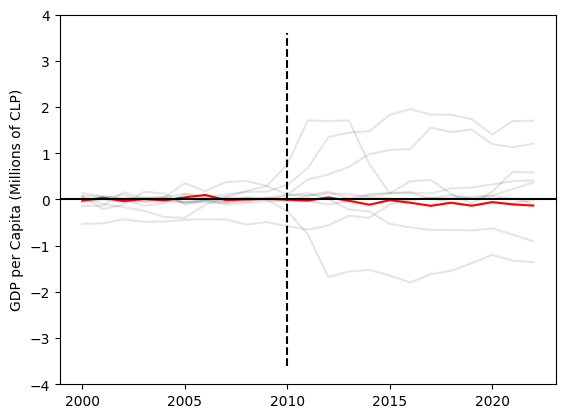

In [8]:
import util
importlib.reload(util)
util.placebo_plot(placebo_test, time_period=range(2000, 2023), mspe_threshold=100, treatment_time=2010,
    divide_by=1000000, y_axis_limit=4, y_axis_label=CHILE_PLOT_YAXIS_LABEL, filename='maule_placebos.png')

We calculate $p$-value of Abadie et al's version of Fisher's exact hypothesis test for no effect of treatment null using the `pvalue` method.

In [9]:
placebo_test.pvalue(treatment_time=2010)

0.6666666666666666

#### Robustness test - Jacknife - Leave out highest weighted region (IX Araucania)

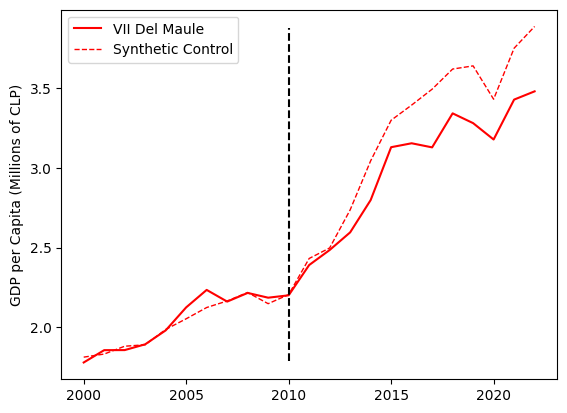

In [10]:
dataprep = Dataprep(
    foo=df,
    predictors=['agropecuario', 'pesca', 'mineria', 'industria_m',
       'electricidad', 'construccion', 'comercio', 'transporte',
       'servicios_financieros', 'vivienda', 'personales', 'publica'],
    predictors_op="mean",
    time_predictors_prior=range(2005, 2009),
    special_predictors=[
        ("gdp_cap", range(2005, 2009), "mean"),
        ("ed_superior_cap", range(2008, 2009), "mean")
    ],
    dependent="gdp_cap",
    unit_variable="region_name",
    time_variable="year",
    treatment_identifier="VII Del Maule",
    controls_identifier=[
        'I De Tarapacá', 'II De Antofagasta', 
       'IV De Coquimbo', 'V De Valparaíso',
       'RMS Región Metropolitana de Santiago', 'IX De La Araucanía',
       'X De Los Lagos', 
       'XI Aysén del General Carlos Ibáñez del Campo',
       'XII De Magallanes y de la Antártica Chilena'
    ],
    time_optimize_ssr=range(1990, 2009),
)

synth_jacknife = Synth()
synth_jacknife.fit(dataprep=dataprep, optim_method="Nelder-Mead", optim_initial="ols")
cl_res = util.synth_plot_chile(synth_jacknife, time_period=range(2000, 2023), treatment_time=2010, filename='chile_jacknife.png')